In [1]:
!pip install implicit==0.4.8

In [2]:
import implicit

In [3]:
implicit.__version__

'0.4.8'

In [4]:
!pip install lightgbm

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [6]:
data = pd.read_csv('../retail_train.csv')
item_features = pd.read_csv('../product.csv')
user_features = pd.read_csv('../hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [7]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [8]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [9]:
recommender

In [10]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1106523, 1044078, 871756, 844179]

In [11]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [12]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 999270, 957267, 846764]

In [13]:
recommender.get_similar_users_recommendation(2375, N=5)

[1101502, 9553048, 5574377, 1038745, 1129805]

In [14]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(5)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886..."


In [15]:
cold_users = np.setdiff1d(result_lvl_1['user_id'], data_train_lvl_1['user_id']).tolist()
result_lvl_1 = result_lvl_1[~result_lvl_1['user_id'].isin(cold_users)]

In [16]:
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))
result_lvl_1['sim_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
result_lvl_1['own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
result_lvl_1['top'] = [recommender.overall_top_purchases[:50] for x in np.arange(len(result_lvl_1))]
result_lvl_1.head(5)

,user_id,actual,als,sim_items,own,top
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1037332, 885290, 1082212, 9834742, 856942, 96...","[824758, 1007512, 9297615, 5577022, 948384, 98...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[5569230, 1017369, 916122, 6534480, 1090931, 1...","[1137346, 5569845, 1044078, 985999, 880888, 81...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[1082212, 999613, 1017325, 925145, 846502, 891...","[1099446, 999714, 1111786, 865528, 9677923, 10...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[878996, 965267, 857006, 1084036, 863632, 1082...","[948650, 5569845, 819308, 878996, 1074754, 110...","[13003092, 972416, 995598, 923600, 1138596, 10...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[7168890, 10285022, 1117556, 7168759, 915586, ...","[5585510, 1044078, 949023, 991874, 9677052, 96...","[998519, 894360, 7147142, 9338009, 896666, 939...","[1029743, 1106523, 5569230, 916122, 844179, 10..."


In [17]:
recall_als = result_lvl_1.apply(lambda row: recall_at_k(row['als'], row['actual'], k=50), axis=1).mean()
recall_sim_items = result_lvl_1.apply(lambda row: recall_at_k(row['sim_items'],
                                                                  row['actual'], k=50), axis=1).mean()
recall_own = result_lvl_1.apply(lambda row: recall_at_k(row['own'], row['actual'], k=50), axis=1).mean()
recall_top = result_lvl_1.apply(lambda row: recall_at_k(row['top'], row['actual'], k=50), axis=1).mean()

print('Recall@50:')
print(f'als      : {recall_als:.6f}')
print(f'sim_items: {recall_sim_items:.6f}')
print(f'own      : {recall_own:.6f}')
print(f'top      : {recall_top:.6f}')

Recall@50:
als      : 0.048279
sim_items: 0.034413
own      : 0.065257
top      : 0.043237


In [18]:
result_lvl_1['own_20']  = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=20))
result_lvl_1['own_100'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=100))
result_lvl_1['own_200'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))
result_lvl_1['own_500'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=500))
result_lvl_1.head(5)

,user_id,actual,als,sim_items,own,top,own_20,own_100,own_200,own_500
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1037332, 885290, 1082212, 9834742, 856942, 96...","[824758, 1007512, 9297615, 5577022, 948384, 98...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[5569230, 1017369, 916122, 6534480, 1090931, 1...","[1137346, 5569845, 1044078, 985999, 880888, 81...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[1082212, 999613, 1017325, 925145, 846502, 891...","[1099446, 999714, 1111786, 865528, 9677923, 10...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[6391541, 1052294, 891423, 936470, 1137010, 11..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[878996, 965267, 857006, 1084036, 863632, 1082...","[948650, 5569845, 819308, 878996, 1074754, 110...","[13003092, 972416, 995598, 923600, 1138596, 10...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[13003092, 972416, 995598, 923600, 1138596, 10...","[13003092, 972416, 995598, 923600, 1138596, 10...","[13003092, 972416, 995598, 923600, 1138596, 10...","[13003092, 972416, 995598, 923600, 1138596, 10..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[7168890, 10285022, 1117556, 7168759, 915586, ...","[5585510, 1044078, 949023, 991874, 9677052, 96...","[998519, 894360, 7147142, 9338009, 896666, 939...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[998519, 894360, 7147142, 9338009, 896666, 939...","[998519, 894360, 7147142, 9338009, 896666, 939...","[998519, 894360, 7147142, 9338009, 896666, 939...","[998519, 894360, 7147142, 9338009, 896666, 939..."


In [19]:
rec_own20  = result_lvl_1.apply(lambda row: recall_at_k(row['own_20'],  row['actual'], k=20),  axis=1).mean()
rec_own50  = result_lvl_1.apply(lambda row: recall_at_k(row['own'],    row['actual'], k=50),  axis=1).mean()
rec_own100 = result_lvl_1.apply(lambda row: recall_at_k(row['own_100'], row['actual'], k=100), axis=1).mean()
rec_own200 = result_lvl_1.apply(lambda row: recall_at_k(row['own_200'], row['actual'], k=200), axis=1).mean()
rec_own500 = result_lvl_1.apply(lambda row: recall_at_k(row['own_500'], row['actual'], k=500), axis=1).mean()
print(f'Own Recall@20 : {rec_own20:.6f}')
print(f'Own Recall@50 : {rec_own50:.6f}')
print(f'Own Recall@100: {rec_own100:.6f}')
print(f'Own Recall@200: {rec_own200:.6f}')
print(f'Own Recall@500: {rec_own500:.6f}')

Own Recall@20 : 0.039284
Own Recall@50 : 0.065257
Own Recall@100: 0.096045
Own Recall@200: 0.135373
Own Recall@500: 0.182053


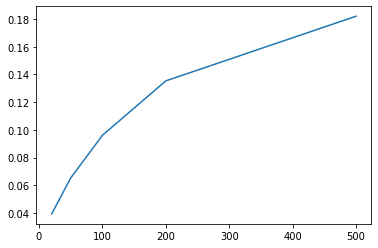

In [20]:
recall = []
recall.append(rec_own20)
recall.append(rec_own50)
recall.append(rec_own100)
recall.append(rec_own200)
recall.append(rec_own500)
plt.plot(np.array([20, 50, 100, 200, 500]), np.array(recall))
plt.show()

recall увеличивается для модели при 500 k. На мой взгляд чем больше товаров, тем лучше шанс сделать верный прогноз

В многоуровневых системах, первая модель может учитывать значительно больше товаров, чтобы втора модель уточняла по ним рекомендации. Однако в одноуровневых рек. системах переизбыток данных может принести к потери качества модели

In [21]:
data_val_lvl_2.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2277416,338,41260573635,636,840173,1,1.99,369,0.0,112,92,0.0,0.0
2277417,338,41260573635,636,1037348,1,0.89,369,-0.3,112,92,0.0,0.0
2277418,338,41260573635,636,5592737,2,1.58,369,-0.2,112,92,0.0,0.0
2277419,338,41260573635,636,7441679,1,3.69,369,0.0,112,92,0.0,0.0
2277420,338,41260573635,636,7442317,1,2.69,369,0.0,112,92,0.0,0.0


In [22]:
own_candidates = result_lvl_1[['user_id', 'own_500']]
own_candidates.head()

,user_id,own_500
0,1,"[856942, 9297615, 5577022, 877391, 9655212, 88..."
1,2,"[911974, 1076580, 1103898, 5567582, 1056620, 9..."
2,4,"[6391541, 1052294, 891423, 936470, 1137010, 11..."
3,6,"[13003092, 972416, 995598, 923600, 1138596, 10..."
4,7,"[998519, 894360, 7147142, 9338009, 896666, 939..."


In [23]:
valid_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index().rename(columns={'item_id': 'actual'})
valid_lvl_2 = valid_lvl_2.merge(own_candidates, on='user_id', how='left')

In [24]:
valid_lvl_2.head()

,user_id,actual,own_500
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 9297615, 5577022, 877391, 9655212, 88..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",NaN
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[13003092, 972416, 995598, 923600, 1138596, 10..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[998519, 894360, 7147142, 9338009, 896666, 939..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[12808385, 981660, 939860, 7410201, 6463874, 8..."


In [25]:
# Точность
valid_lvl_2[valid_lvl_2.own_500.notna()].apply(lambda row: precision_at_k(row['own_500'],row['actual'], k=5), axis=1).mean()

0.15070496083550916

In [26]:
# Новые признаки для товара
def new_item_features(data, item_features):
    
    # Цена
    data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))
    new_item_features = item_features.merge(data, on='item_id', how='left')
    
    # Средняя цена по категории
    avg_price_by_cat = new_item_features.groupby('commodity_desc')['price'].mean()
    item_features = item_features.merge(avg_price_by_cat, on='commodity_desc', how='left').rename(columns={'price_x': 'price', 'price_y': 'avg_price'})    

    # Количество продаж и среднее количество продаж товара
    item_qnt = new_item_features.groupby(['item_id'])['quantity'].count().reset_index()
    item_qnt.rename(columns={'quantity': 'quantity_of_sales'}, inplace=True)
    item_qnt['quantity_of_sales_per_week'] = item_qnt['quantity_of_sales'] / new_item_features['week_no'].nunique()
    item_features = item_features.merge(item_qnt, on='item_id')
    
    return item_features

In [27]:
# Новые признаки для пользователя
def new_user_features(data, user_features):
    
    new_user_features = user_features.merge(data, on='user_id', how='left')

    # Сумма чека
    basket = new_user_features.groupby(['user_id'])['sales_value'].sum().reset_index()
    baskets_qnt = new_user_features.groupby('user_id')['basket_id'].count().reset_index()
    baskets_qnt.rename(columns={'basket_id': 'baskets_qnt'}, inplace=True)
    # Средний недельный чек
    average_basket = basket.merge(baskets_qnt)
    average_basket['average_basket'] = average_basket.sales_value / average_basket.baskets_qnt
    average_basket['sum_per_week'] = average_basket.sales_value / new_user_features.week_no.nunique()
    average_basket = average_basket.drop(['sales_value', 'baskets_qnt'], axis=1)
    user_features = user_features.merge(average_basket, on='user_id')

    return user_features

In [28]:
item_features = new_item_features(data_train_lvl_2, item_features)
user_features = new_user_features(data_train_lvl_2, user_features)

In [29]:
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,price,quantity_of_sales,quantity_of_sales_per_week
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,2.049175,0,0.0
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,2.569208,0,0.0
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,1.848519,0,0.0
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,1.288902,0,0.0
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,2.348123,0,0.0


In [30]:
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,average_basket,sum_per_week
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,2.569774,56.963333
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,2.085000,31.275000
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,2.472683,50.690000
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,6.248079,184.318333
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,3.435714,4.008333


In [31]:
def train_test_preprocessing(data):    
    
    users_lvl_2 = pd.DataFrame(data['user_id'].unique())
    users_lvl_2.columns = ['user_id']

    train_users = data_train_lvl_1['user_id'].unique()
    train_users.shape

    users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]
    users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=500))
    
    s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'item_id'
    users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
    users_lvl_2['flag'] = 1

    targets_lvl_2 = data[['user_id', 'item_id']].copy()
    targets_lvl_2['target'] = 1  
    targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
    targets_lvl_2['target'].fillna(0, inplace= True)
    targets_lvl_2.drop('flag', axis=1, inplace=True)

    targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
    targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

    X = targets_lvl_2.drop('target', axis=1)
    y = targets_lvl_2['target'].ravel()
    
    return X, y

In [32]:
X_train, y_train = train_test_preprocessing(data_train_lvl_2)

In [33]:
X_train.head().T

,0,1,2,3,4
user_id,2070,2070,2070,2070,2070
item_id,1105426,1097350,879194,948640,928263
manufacturer,69,2468,69,1213,69
department,DELI,GROCERY,DRUG GM,DRUG GM,DRUG GM
brand,Private,National,Private,National,Private
commodity_desc,SANDWICHES,DOMESTIC WINE,DIAPERS & DISPOSABLES,ORAL HYGIENE PRODUCTS,DIAPERS & DISPOSABLES
sub_commodity_desc,SANDWICHES - (COLD),VALUE GLASS WINE,BABY DIAPERS,WHITENING SYSTEMS,BABY DIAPERS
curr_size_of_product,,4 LTR,14 CT,3 OZ,13 CT
price,3.825792,8.600625,10.832599,3.253559,10.832599
quantity_of_sales,3,1,0,0,10


In [34]:
cat_feats = ['manufacturer', 'department', 'brand', 'commodity_desc', 'sub_commodity_desc',
             'curr_size_of_product', 'age_desc', 'marital_status_code', 'income_desc',
             'homeowner_desc', 'hh_comp_desc', 'household_size_desc', 'kid_category_desc']

X_train[cat_feats] = X_train[cat_feats].astype('category')
X_test, y_test = train_test_preprocessing(data_val_lvl_2)
X_test[cat_feats] = X_test[cat_feats].astype('category')

In [35]:
%%time
lgb = LGBMClassifier(objective='binary', max_depth = 7)
lgb.fit(X_train, y_train)

CPU times: total: 22.6 s
Wall time: 1.51 s


LGBMClassifier(max_depth=7, objective='binary')

In [36]:
feature = list(zip(X_train.columns.tolist(), lgb.feature_importances_))
feature = pd.DataFrame(feature, columns=['feature', 'value'])
feature

,feature,value
0,user_id,249
1,item_id,99
2,manufacturer,415
3,department,0
4,brand,6
5,commodity_desc,95
6,sub_commodity_desc,636
7,curr_size_of_product,377
8,price,46
9,quantity_of_sales,319


In [37]:
def get_important_features(model, X_train, y_train):
    # Отбор важных признаков
    model.fit(X_train, y_train)
    feature = list(zip(X_train.columns.tolist(), model.feature_importances_))
    feature = pd.DataFrame(feature, columns=['feature', 'value'])
    features = feature.loc[feature.value > 0, 'feature'].tolist()
    return features

In [38]:
important_features = get_important_features(lgb, X_train, y_train)
important_features

['user_id',
 'item_id',
 'manufacturer',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'price',
 'quantity_of_sales',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'average_basket',
 'sum_per_week']

In [39]:
%%time
lgb.fit(X_train[important_features], y_train)

CPU times: total: 24 s
Wall time: 1.57 s


LGBMClassifier(max_depth=7, objective='binary')

In [40]:
test_preds_proba = lgb.predict_proba(X_test[important_features])[:, 1]
test_preds_proba[:10]

array([2.52090948e-02, 2.52090948e-02, 3.34873450e-02, 3.34873450e-02,
       2.32640959e-04, 4.57774428e-02, 2.98480544e-04, 5.19538018e-03,
       2.36258457e-02, 3.58943038e-01])

In [41]:
def get_final_recomendation(X_test, test_preds_proba, data_val_lvl_2):
    
    X_test['predict_proba'] = test_preds_proba
    X_test.sort_values(['user_id', 'predict_proba'], ascending=[True, False], inplace=True)
    lgb_candidates = X_test.groupby('user_id').head(5).groupby('user_id')['item_id'].unique().reset_index()
    
    result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index().rename(columns={'item_id': 'actual'})
    result_lvl_2 = result_lvl_2.merge(lgb_candidates, on='user_id', how='left')
    result_lvl_2.rename(columns={'item_id': 'lgb'}, inplace=True)
    
    return result_lvl_2

In [42]:
result_lvl_2 = get_final_recomendation(X_test, test_preds_proba, data_val_lvl_2)

In [43]:
result_lvl_2.head()

,user_id,actual,lgb
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082185, 1029743, 8293439]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1082185, 1029743, 1106523, 992529, 1110244]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1082185, 1029743, 845208]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1082185, 1029743]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1082185, 1029743]"


In [44]:
# Точность
result_lvl_2[result_lvl_2.lgb.notna()].apply(lambda row: precision_at_k(row['lgb'], row['actual'], k=5), axis=1).mean()

0.252140522875817

Метрика precision at 5 выросла почти в полтора раза